In [193]:
import numpy as np
import matplotlib.pyplot as plt

In [194]:
def three_dof_body_axes(Fx, Fz, My, u0=0.0, w0=0.0, theta0=0.0, q0=0.0, pos0=[0.0, 0.0], mass=0, inertia=0.0, g=9.81, dt=0.01, duration=10):
    # ensure pos0 is a float array
    pos = np.array(pos0, dtype=float)
    
    # initial conditions
    u = u0
    w = w0
    theta = theta0
    q = q0
    vel = np.array([u, w])
    
    # initial acceleration
    ax = Fx[0] / mass
    az = Fz[0] / mass - g
    
    # history lists to store values
    theta_list = [theta]
    q_list = [q]
    dqdt_list = [0]
    pos_list = [pos.copy()]
    velocity_list = [vel.copy()]
    acceleration_list = [np.array([ax, az])]

    # time integration using Euler's method
    for t in np.arange(0, duration + dt, dt):  # start at 0 and end at 'duration'
        # calculate accelerations
        ax = Fx[int(t/dt)] / mass
        az = Fz[int(t/dt)] / mass - g
        
        # calculate angular acceleration
        dqdt = My[int(t/dt)] / inertia
        
        # update velocities
        u += ax * dt
        w += az * dt
        q += dqdt * dt
        
        # update positions
        pos += vel * dt
        vel = np.array([u, w])
        
        # update angle
        theta += q * dt
        
        # store data in list
        theta_list.append(theta)
        q_list.append(q)
        dqdt_list.append(dqdt)
        pos_list.append(pos.copy())
        velocity_list.append(vel.copy())
        acceleration_list.append(np.array([ax, az]))
        
        # stop if the rocket returns to ground level
        if pos[1] <= 0 and t > 2:  # allow some time for launch
            break
    
    return {
        'theta' : np.array(theta_list),
        'q' : np.array(q_list),
        'dqdt' : np.array(dqdt_list),
        'pos' : np.array(pos_list),
        'velocity' : np.array(velocity_list),
        'acceleration' : np.array(acceleration_list)
    }

In [195]:
def generate_thrust_profile(duration, thrust_duration, peak_thrust, dt=0.01):
    thrust_profile = []
    for t in np.arange(0, duration + dt, dt):
        if t < 0.1 * thrust_duration:
            # ignition and rapid rise (modeled as quadratic rise)
            thrust = peak_thrust * (10 * t / thrust_duration)**2
        elif t < 0.3 * thrust_duration:
            # peak thrust
            thrust = peak_thrust
        elif t < thrust_duration:
            # decay phase (modeled as linear decay)
            thrust = peak_thrust * (1 - (t - 0.3 * thrust_duration) / (0.7 * thrust_duration))
        else:
            # burnout
            thrust = 0
        thrust_profile.append(thrust)
    return np.array(thrust_profile)

In [196]:
# parameters
mass = 0.543 # kg
inertia = 0.048 # kg*m^2
g = 9.81 # m/s^2
peak_thrust = 15 # N
thrust_duration = 3.5 # s
simulation_duration = 30 # s
dt = 0.01 # time step
moment_arm = 0.28 # meters
gimbal_angle = -0.05 # radian

In [197]:
# initial conditions
u0 = 0.0 # initial velocity in x (body axis)
w0 = 0.0 # initial velocity in z (body axis)
theta0 = 0.0 # initial pitch angle
q0 = 0.0 # initial pitch rate
pos0 = [0.0, 0.0] # initial position [x, z]

In [198]:
# generate thrust profile
# thrust_profile = generate_thrust_profile(simulation_duration, thrust_duration, peak_thrust, dt)
with open('profiles/f15_thrust_extended.npy', 'rb') as f:
    thrust_profile = np.load(f)
print(max(thrust_profile))
print(len(thrust_profile))

25.310395010592096
3001


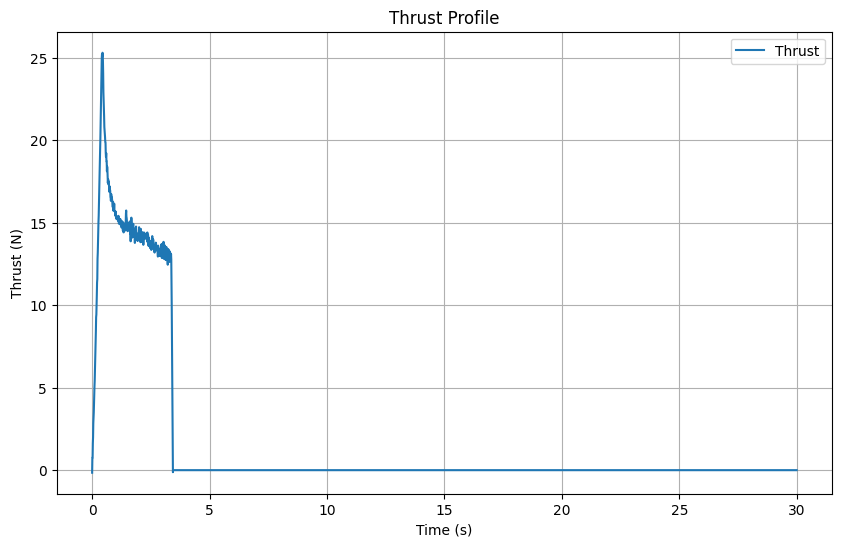

In [199]:
# plotting the thrust
time_range = np.arange(0, simulation_duration + dt, dt)

plt.figure(figsize=(10, 6))
plt.plot(time_range, thrust_profile, label='Thrust')

# annotate the end of the stages
# plt.axvline(x=0.1 * thrust_duration, color='red', linestyle='--', label='End of rapid rise')
# plt.axvline(x=0.3 * thrust_duration, color='green', linestyle='--', label='End of peak thrust')
# plt.axvline(x=thrust_duration, color='orange', linestyle='--', label='End of decay phase (Burnout)')

plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')
plt.title('Thrust Profile')
plt.legend()
plt.grid()
plt.show()

In [200]:
# initialize forces and moments
Fx = np.sin(gimbal_angle) * thrust_profile # horizontal thrust
Fz = np.cos(gimbal_angle) * thrust_profile # vertical thrust
My = Fx * moment_arm # pitching moment (torque)

print(Fx)
print(Fz)
print(My)

[ 0.00776821 -0.03772264 -0.03788651 ... -0.         -0.
 -0.        ]
[-0.15523479  0.7538239   0.75709857 ...  0.          0.
  0.        ]
[ 0.0021751  -0.01056234 -0.01060822 ... -0.         -0.
 -0.        ]


In [201]:
# simulation
results = three_dof_body_axes(Fx, Fz, My, u0, w0, theta0, q0, pos0, mass, inertia, g, dt, simulation_duration)

time = np.arange(0, len(results['pos']) * dt, dt)
theta = results['theta']
q = results['q']
pos = results['pos']
velocity = results['velocity']
acceleration = results['acceleration']

print(acceleration[:, 1])
print(len(time))
print(len(pos))

[-10.09588359 -10.09588359  -8.42174236 ...  -9.81        -9.81
  -9.81      ]
1671
1671


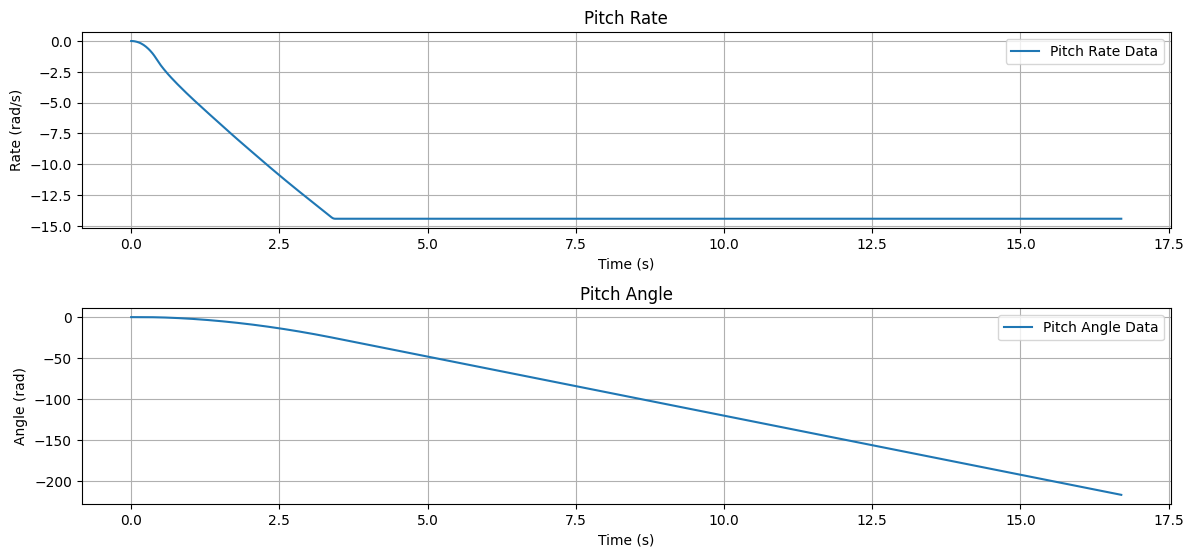

In [202]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, q, label='Pitch Rate Data')
plt.xlabel('Time (s)')
plt.ylabel('Rate (rad/s)')
plt.title('Pitch Rate')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(time, theta, label='Pitch Angle Data')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Pitch Angle')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

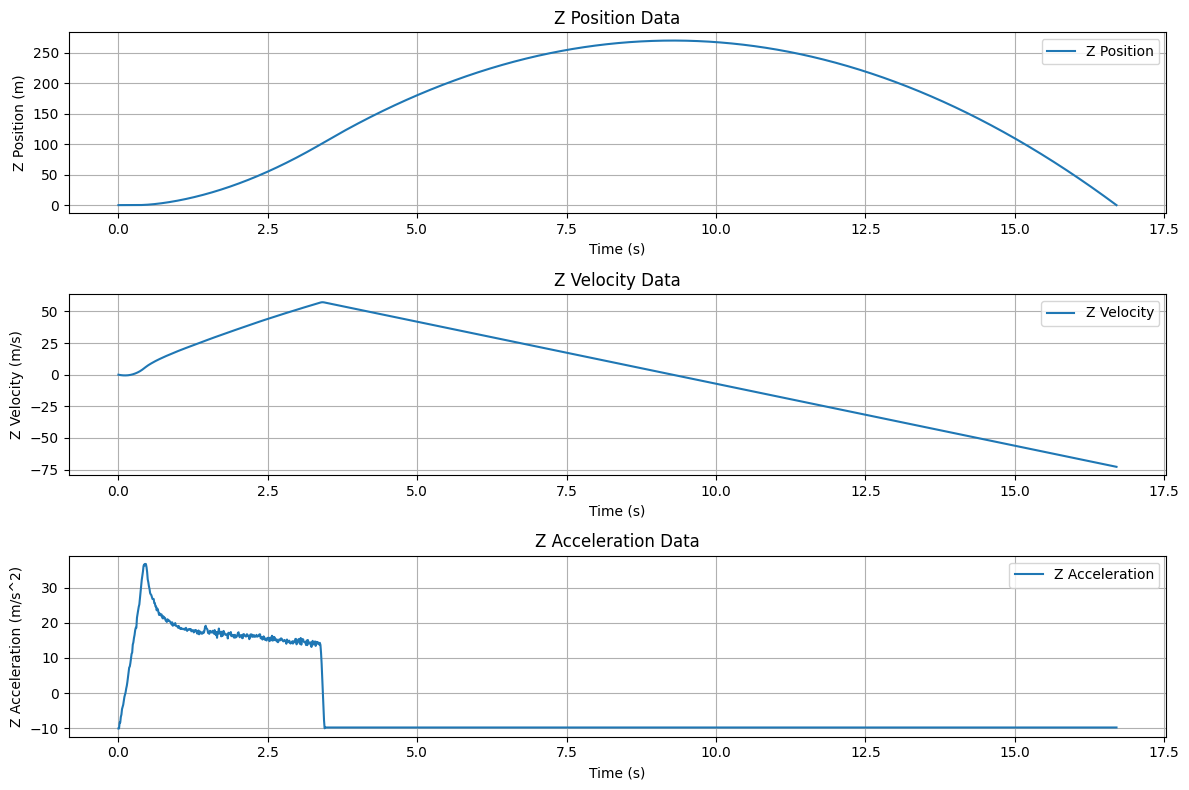

In [203]:
# plot data (Z axis)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, pos[:, 1], label='Z Position')
plt.xlabel('Time (s)')
plt.ylabel('Z Position (m)')
plt.title('Z Position Data')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(time, velocity[:, 1], label='Z Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Z Velocity (m/s)')
plt.title('Z Velocity Data')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(time, acceleration[:, 1], label='Z Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Z Acceleration (m/s^2)')
plt.title('Z Acceleration Data')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

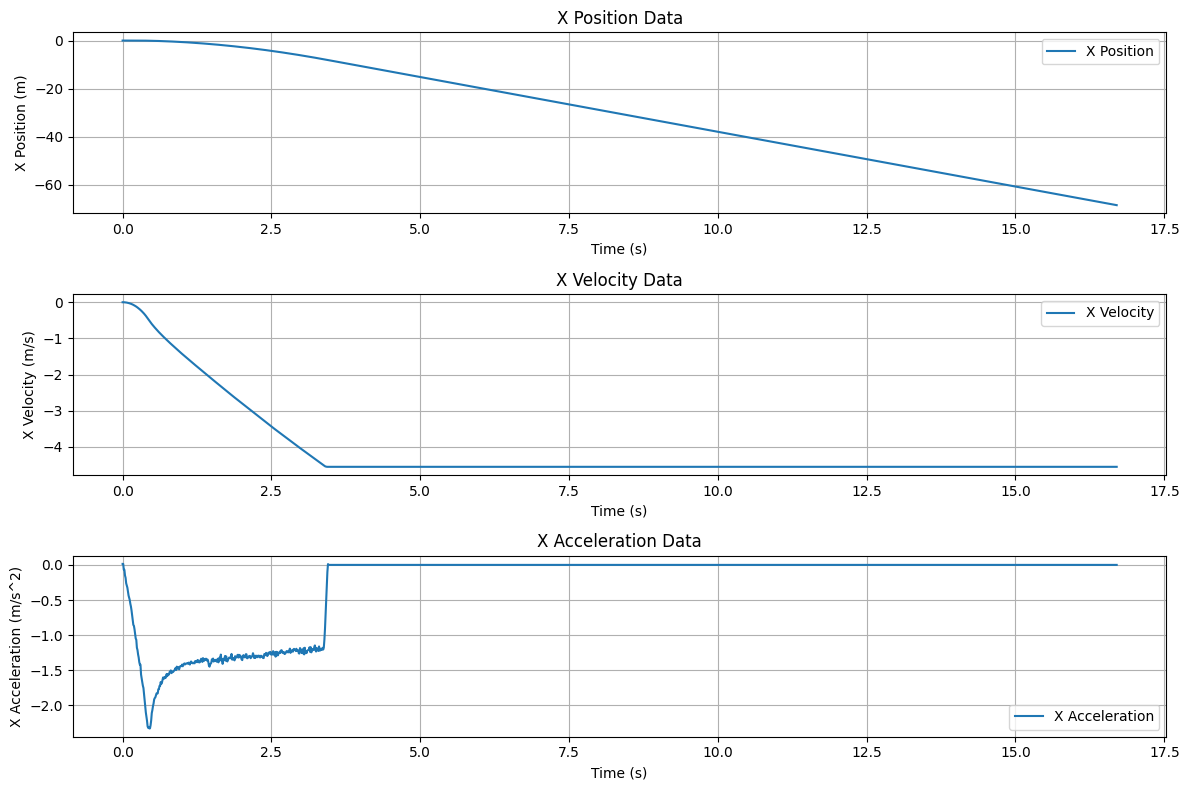

In [204]:
# plot data (X axis)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, pos[:, 0], label='X Position')
plt.xlabel('Time (s)')
plt.ylabel('X Position (m)')
plt.title('X Position Data')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(time, velocity[:, 0], label='X Velocity')
plt.xlabel('Time (s)')
plt.ylabel('X Velocity (m/s)')
plt.title('X Velocity Data')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(time, acceleration[:, 0], label='X Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('X Acceleration (m/s^2)')
plt.title('X Acceleration Data')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

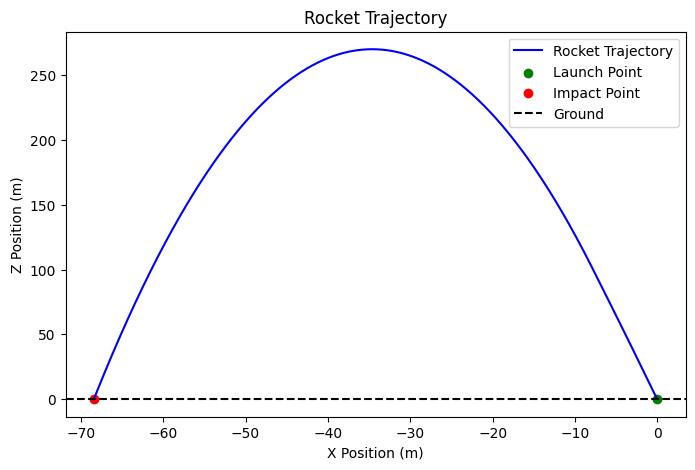

In [205]:
# plot trajectory of rocket (2D)
plt.figure(figsize=(8, 5))

plt.plot(pos[:, 0], pos[:, 1], label='Rocket Trajectory', color='blue')
plt.scatter(pos[0, 0], pos[0, 1], color='green', label='Launch Point') # mark the launch point
plt.scatter(pos[-1, 0], pos[-1, 1], color='red', label='Impact Point') # mark the impact point
plt.axhline(0, color='black', linestyle='--', label='Ground') # ground level
plt.xlabel('X Position (m)')
plt.ylabel('Z Position (m)')
plt.title('Rocket Trajectory')
plt.legend()

plt.show()